Distributie: 250 promovati din 500 (50.0%)
Raspuns: Datele sunt BALANSATE.

Ecuatia granitei de decizei:
0 = 0.18 + 3.71 * Studiu_std + 4.97 * Somn_std


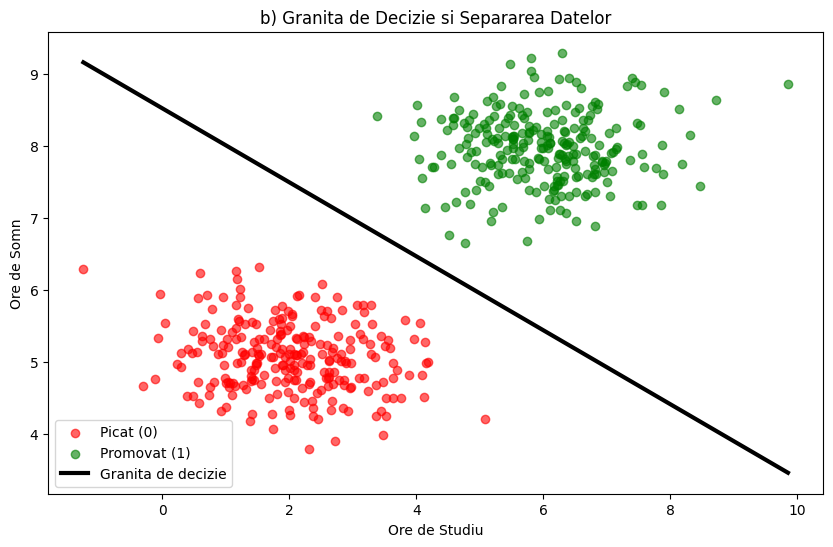

Datele NU sunt perfect separate.
Granita de decizie trece prin zona de suprapunere dintre studenti picati si promovati.
Coeficient Studiu (beta1): 3.708
Coeficient Somn   (beta2): 4.975
Raspuns: Orele de SOMN influenteaza mai mult promovabilitatea.
(Magnitudinea coeficientului 4.97 este mai mare decat 3.71)


In [4]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

#a
df = pd.read_csv('date_promovare_examen.csv')

df.columns = ['Studiu', 'Somn', 'Promovare']

X_studiu = df['Studiu'].values
X_somn = df['Somn'].values
y_obs = df['Promovare'].values

nr_promovati = df['Promovare'].sum()
total = len(df)
procent_promovare = nr_promovati / total

print(f"Distributie: {nr_promovati} promovati din {total} ({procent_promovare:.1%})")

if 0.4 <= procent_promovare <= 0.6:
    print("Raspuns: Datele sunt BALANSATE.\n")
else:
    print("Raspuns: Datele sunt NEBALANSATE.\n")

mean_st, std_st = X_studiu.mean(), X_studiu.std()
studiu_s = (X_studiu - mean_st) / std_st

mean_so, std_so = X_somn.mean(), X_somn.std()
somn_s = (X_somn - mean_so) / std_so

X_data = np.stack([studiu_s, somn_s], axis=1)

with pm.Model() as model_logistic:
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    betas = pm.Normal('betas', mu=0, sigma=2, shape=2)

    z = alpha + pm.math.dot(X_data, betas)
    p = pm.math.sigmoid(z)

    y_pred = pm.Bernoulli('y_pred', p=p, observed=y_obs)

    idata = pm.sample(2000, tune=2000, return_inferencedata=True, progressbar=False, target_accept=0.95)


# b
summary = az.summary(idata, var_names=['alpha', 'betas'])
alpha_m = summary.loc['alpha', 'mean']
beta1_m = summary.loc['betas[0]', 'mean'] # Studiu
beta2_m = summary.loc['betas[1]', 'mean'] #Somn

print("Ecuatia granitei de decizei:")
print(f"0 = {alpha_m:.2f} + {beta1_m:.2f} * Studiu_std + {beta2_m:.2f} * Somn_std")

plt.figure(figsize=(10, 6))

plt.scatter(X_studiu[y_obs==0], X_somn[y_obs==0], c='red', label='Picat (0)', alpha=0.6)
plt.scatter(X_studiu[y_obs==1], X_somn[y_obs==1], c='green', label='Promovat (1)', alpha=0.6)

x_vals = np.linspace(X_studiu.min(), X_studiu.max(), 100)
x_vals_s = (x_vals - mean_st) / std_st

y_vals_s = -(alpha_m + beta1_m * x_vals_s) / beta2_m
y_vals = y_vals_s * std_so + mean_so
plt.plot(x_vals, y_vals, 'k-', linewidth=3, label='Granita de decizie')

plt.xlabel('Ore de Studiu')
plt.ylabel('Ore de Somn')
plt.legend()
plt.title('b) Granita de Decizie si Separarea Datelor')
plt.show()

print("Datele NU sunt perfect separate.")
print("Granita de decizie trece prin zona de suprapunere dintre studenti picati si promovati.")


#c
print(f"Coeficient Studiu (beta1): {beta1_m:.3f}")
print(f"Coeficient Somn   (beta2): {beta2_m:.3f}")

if abs(beta1_m) > abs(beta2_m):
    print("Raspuns: Orele de STUDIU influenteaza mai mult promovabilitatea.")
    print(f"(Magnitudinea coeficientului {abs(beta1_m):.2f} este mai mare decat {abs(beta2_m):.2f})")
else:
    print("Raspuns: Orele de SOMN influenteaza mai mult promovabilitatea.")
    print(f"(Magnitudinea coeficientului {abs(beta2_m):.2f} este mai mare decat {abs(beta1_m):.2f})")